In [11]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk')

import os
if not os.path.isdir("_cache"):
    os.mkdir("_cache")

# Build the iTree

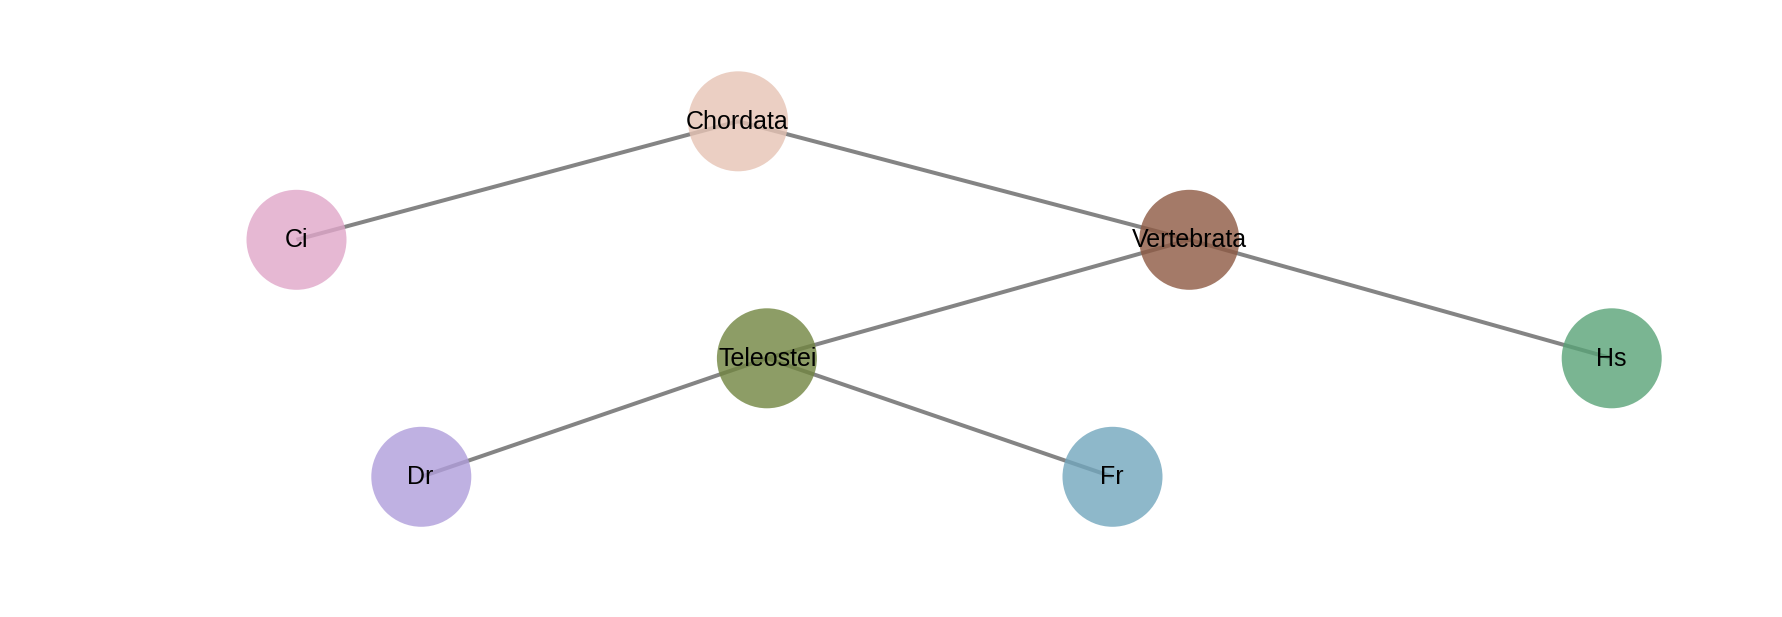

In [12]:
from Bio import Phylo

tree = Phylo.read(open('_data/bZIP.species','r'),format='newick')

tree.rooted = True

sTree = Phylo.to_networkx(tree)

for node in sTree.nodes():
    sTree.node[node]['S'] = str(node)

from pinfer import vis_tree

vis_tree(sTree,node_cat_string='S', node_size=1e4, edge_width=4.0)

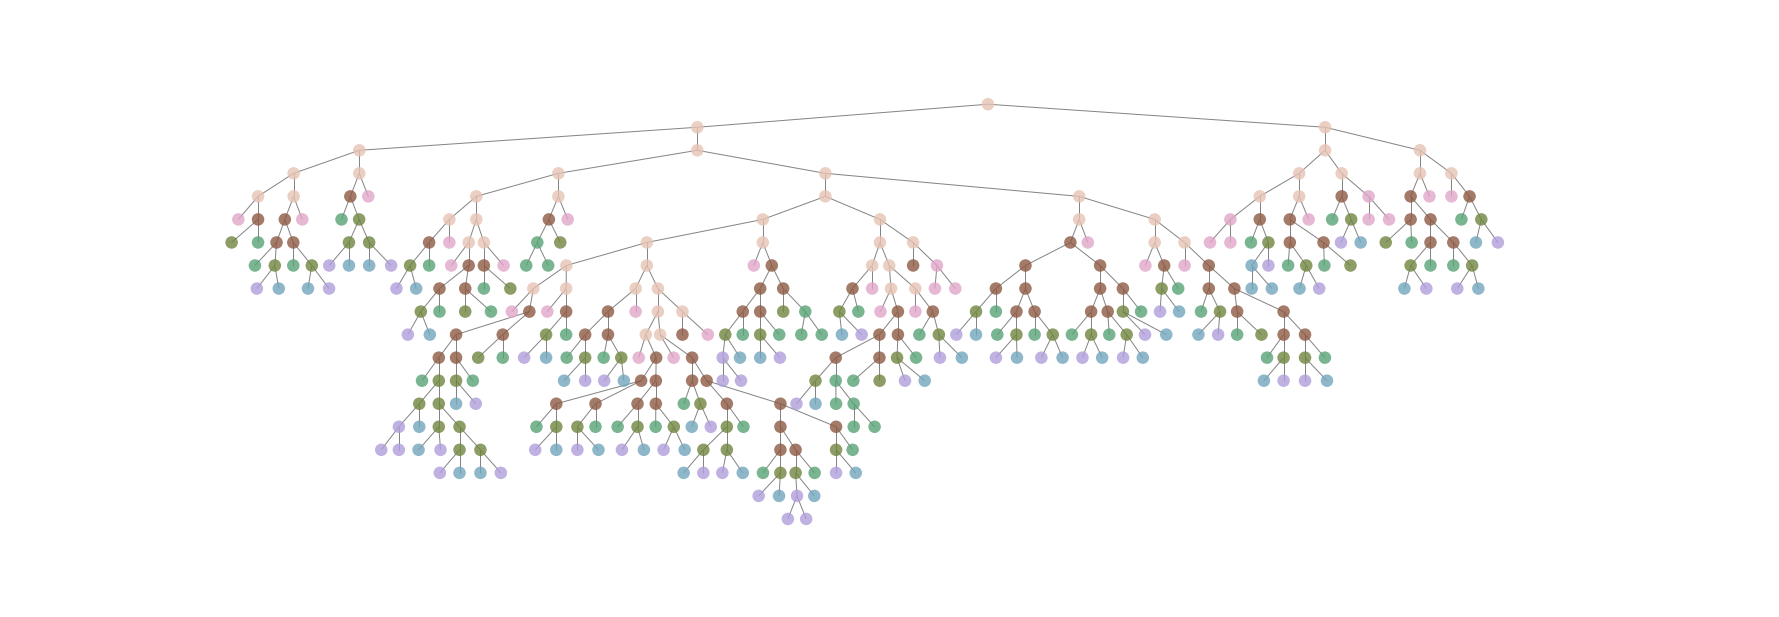

In [13]:
from pinfer.io import load_notung_nhx

gTree = load_notung_nhx('_data/bZIP.reatt.ntg.div')

import pickle
pickle.dump(gTree,open('_cache/gTree.pickle','wb'))

from pinfer import vis_tree

# neato, dot, twopi, circo, fdp, nop, wc, acyclic, gvpr, gvcolor, ccomps, sccmap, tred, sfdp
vis_tree(gTree,node_cat_string='S', layout='dot', edge_width=1.0)

# Helper functions...

In [14]:

import numpy as np

from pinfer.itree.utils import get_inode_name


def process_ppi_results(path, threshold=None):

    observations = {}

    with open(path, 'r') as f:

        for line in f.readlines():
            if line[0] in ['/', '#']:
                continue

            geneA, geneB, score = line.split()

            iname = get_inode_name(geneA, geneB)

            score = float(score)

            if not threshold:
                observations[iname] = score
            else:
                if score > threshold:
                    observations[iname] = [0, 1]
                else:
                    observations[iname] = [1, 0]

    return observations


k_loss  = 0.9219
r_loss  = 5.8860
d0_loss = 1.2887

k_gain  = 0.0809
r_gain  = 2.9495
d0_gain = 1.6409


import functools

scaling_factor = 1.0


def _logistic(x, k=None, r=None, d0=None):
    zeroLoss = k / (1. + np.exp(-r * (-d0)))
    pLoss    = k / (1. + np.exp(-r * ((x / scaling_factor) - d0)))

    return pLoss - zeroLoss

p_loss = functools.partial(_logistic, k=k_loss, r=r_loss, d0=d0_loss)
p_gain = functools.partial(_logistic, k=k_gain, r=r_gain, d0=d0_gain)


def add_iTree_CPTs(iTree):

    for s, t in iTree.edges():

        evol_dist = iTree.edge[s][t]['evol_dist'] * 1.0

        CPT = np.zeros((2, 2))
        CPT[0, :] = np.array([1 - p_gain(evol_dist), p_gain(evol_dist)])
        CPT[1, :] = np.array([p_loss(evol_dist), 1 - p_loss(evol_dist)])

        iTree.node[t]['CPT'] = CPT


import networkx as nx

strongMu  = 33.9178
strongSig = 5.3487
nonMu     = 11.4614
nonSig    = 9.2827

cut_value = 30.6

from scipy.stats import norm

strong_CDF = functools.partial(norm.cdf, loc=strongMu, scale=strongSig)
non_CDF    = functools.partial(norm.cdf, loc=nonMu, scale=nonSig)


def annotate_observations(iTree, observations):

    # remove all observation nodes
    iTree.remove_nodes_from([n for n in iTree.nodes()
                             if iTree.node[n].get('node_type', '') == 'observation'])
    # remove all existing observations
    [iTree.node[n].pop('observation', None) for n in iTree.nodes()]

    n_to_annotate = iTree.nodes()

    CPT = np.zeros((2, 2))
    # CPT[0, :] = np.array([0.99, 0.01])
    # CPT[1, :] = np.array([0.01, 0.99])
    CPT[0, :] = np.array([non_CDF(cut_value), 1 - non_CDF(cut_value)])
    CPT[1, :] = np.array([1 - strong_CDF(cut_value), strong_CDF(cut_value)])

    for node in n_to_annotate:

        observation = observations.get(node, None)

        if not observation:
            continue

        assert not iTree.succ[node]

        new_node = 'observation_' + node

        iTree.add_node(new_node,
                       name=new_node,
                       observation=observation,
                       CPT=CPT,
                       node_type='observation')

        iTree.add_edge(node, new_node)

    # we assume a 50% chance of the ancestral self-interaction existing
    iTree.node[nx.topological_sort(iTree)[0]]['prior'] = [0.5, 0.5]

In [15]:
# from tools.iTree import process_ppi_results, add_iTree_CPTs

from pinfer.itree import build_itree

iTree2016 = build_itree(gTree)

iTree2016.graph['pos'] = nx.graphviz_layout(iTree2016, prog='dot')

import pickle
pickle.dump(iTree2016,open('_cache/iTree2016RAW.pickle','wb'))

# Visualise iTree2016

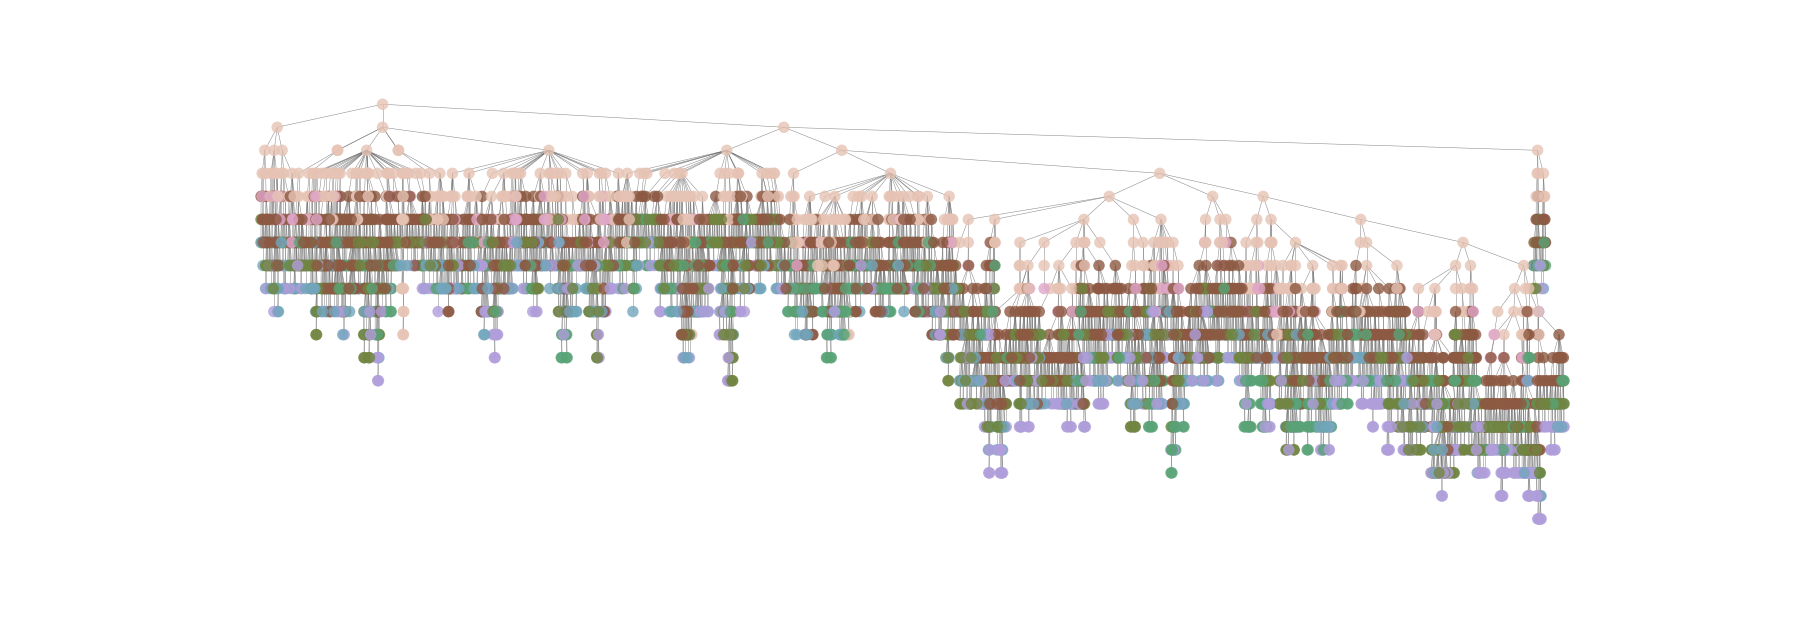

In [16]:
iTree2016 = pickle.load(open('_cache/iTree2016RAW.pickle','rb'))


vis_tree(iTree2016,node_cat_string='S', node_size=1.5 * float(6e5) / len(iTree2016.nodes()))

In [17]:
print(len(iTree2016.nodes()))

6850


# Infer ancestral states

In [18]:
from collections import OrderedDict
results = OrderedDict()

for noise_level in [0, 10, 20]:
    
    iTree2016 = pickle.load(open('_cache/iTree2016RAW.pickle','rb'))
    
    ppi_path = '_data/bZIP_n%d.ppi' % noise_level

    observations = process_ppi_results(ppi_path, threshold=30.6)

    add_iTree_CPTs(iTree2016)

    annotate_observations(iTree2016, observations)




    from pinfer.infer import analyse_polytree

    iTree2016 = analyse_polytree(iTree2016,verbose=False, pivot_node=nx.topological_sort(iTree2016)[0])

    from pinfer.itree.utils import get_inode_name

    predictions = []
    truth       = []

    count = 0
    for line in open('_data/groundtruth_chordata.prob','r').readlines():
        geneA, geneB, score = line.split()
        inode = get_inode_name(geneA, geneB)
        score = float(score) > 0.5

        truth.append(score)
        predictions.append(iTree2016.node[inode]['belief'][1])

    from sklearn import metrics

    fpr, tpr, thresholds = metrics.roc_curve(truth, predictions)
    
    auc = metrics.auc(fpr, tpr)
    
    results[noise_level] = (fpr, tpr, auc)

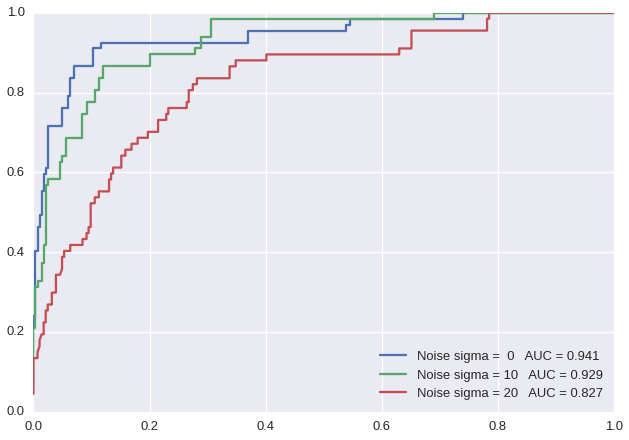

In [19]:
ax = plt.subplot(111)
for noise_level, (fpr, tpr, auc) in results.items():
    ax.plot(fpr, tpr, label='Noise sigma = %2d   AUC = %0.3f' % (noise_level, auc))
ax.legend(loc=4);